## Use of ConceptNet

In [1]:
import time
import importlib
import torch
from torch import nn
import torch.nn.functional as F
from Knowledge.ConceptNet import ConceptNet

In [2]:
conceptnet = ConceptNet('./Data/', numberbatch=False)
GLoVe = nn.Embedding.from_pretrained(conceptnet.concept_embedding.vectors).cuda()

[ConceptNet Constructing] Using GLoVe
[ConceptNet Constructing] Load ConceptNet from file


100%|██████████| 2206782/2206782 [00:10<00:00, 215997.68it/s]


In [19]:
import networkx as nx
import time


s = time.time()

nx.shortest_path_length(conceptnet.conceptnet, 'hydrogen', 'kiwifruit', weight='weight')

1.8277370145258411

In [27]:
print(torch.zeros(300).shape)
t = 0
for i in range(30000):
    v1 = torch.rand(300)
    nt1 = time.time()
    F.cosine_similarity(conceptnet.concept_embedding['food'], v1, dim=0)
    nt2 = time.time()
    t += (nt2-nt1)
t / 30000

torch.Size([300])


1.615630785624186e-05

In [49]:
t1 = time.time()
for i in range(100):
    word_list = ['food', 'food', 'food']
    word_embeddings = [conceptnet.concept_embedding[n] for n in word_list]
    stacked_embeddings = torch.stack(word_embeddings)
    v1 = torch.rand(300).repeat(stacked_embeddings.size(0), 1)
    F.cosine_similarity(stacked_embeddings, v1, dim=1)
t2 = time.time()
(t2-t1)/100

0.0

In [75]:
conceptnet.bidirectional_reasoning(['home'], 'chicken', torch_calculation=False)

3.397620242574941e-05


0

In [76]:
conceptnet.bidirectional_reasoning(['home', 'food'], 'chicken', torch_calculation=True)

8.984844887347581e-06


In [79]:
a = 4
if False:
    a = 3
a

4

In [ ]:
f = open('../Training/Data/tgconv_train.json')

## Most Relevant Concepts

In [3]:
start_concept = 'food'

print(conceptnet.conceptnet['food']['cake'])

# def min_relations(rels):
#     result = []
#     for k in rels:
#         rel = rels[k]
#         min_weight = min([rel[t]['weight'] for t in rel])
#         result.append({'tail': k, 'weight': min_weight})
#
#     return result

start_time = time.time()
# neighbours = conceptnet.conceptnet[start_concept]
# min_rels = min_relations(neighbours)
# min_rels = sorted(min_rels, key=lambda x: x['weight'])
min_rels = conceptnet.min_neighbour_target(start_concept, 'hotel')
top_concepts = [t['w'] for t in min_rels[:10]]
end_time = time.time()
print(top_concepts)
print(end_time-start_time,'s')

{0: {'rel': 'isa', 'weight': 2.0}, 1: {'rel': 'relatedto', 'weight': 0.09375585974123382}, 2: {'rel': 'relatedto', 'weight': 1.0}}
[0.28868360277136257, 0.28868360277136257, 0.3639998195185976, 0.3834355828220859, 0.49224013331582106, 0.49877783659272334, 0.5, 0.507137973864777, 0.5122971984779815, 0.5129334385455407]
61.62500286102295 s


### Reasoning Size

In [10]:
s = [start_concept]
hops = 5

surrounding_concepts = []
for i in range(hops):
    t = []
    while len(s) != 0:
        head_entity = s.pop(0)
        if head_entity in surrounding_concepts:
            continue
        surrounding_concepts.append(head_entity)
        t.extend(conceptnet.adjacent(head_entity))
    t = list(set(t))
    print(len(t))
    s = t

print(len(surrounding_concepts))

1312
52933
341322


KeyboardInterrupt: 

### Bidirectional Reasoning

### Embedding Efficiency Test

In [3]:
from sentence_transformers import SentenceTransformer, util
import time


# encoder efficiency test
encoder = SentenceTransformer('sentence-transformers/sentence-t5-base')

word_1 = 'apple'
word_2 = 'food'

embedding_result = 0

start_time = time.time()
word_2_encoded = encoder.encode(word_2, convert_to_tensor=True)
for _ in range(100):
    embedding_result = util.cos_sim(encoder.encode(word_1, convert_to_tensor=True), word_2_encoded).item()
end_time = time.time()
print((end_time-start_time)/100, 's')
print(embedding_result)

word_1s = [word_1] * 100
start_time = time.time()
word_1s_encoded = encoder.encode(word_1s, convert_to_tensor=True)
word_2_encoded = encoder.encode(word_2, convert_to_tensor=True)
for embedding in word_1s_encoded:
    embedding_result = util.cos_sim(embedding, word_2_encoded).item()
end_time = time.time()
print((end_time-start_time)/100, 's')
print(embedding_result)

0.011010620594024658 s
0.8444115519523621
0.0005421233177185058 s
0.8444117307662964


### SpaCy Efficiency Test

In [10]:
import spacy

nlp = spacy.load('en_core_web_lg')

spacy_result = 0

start_time = time.time()
for _ in range(100):
    doc_1 = nlp(word_1)
    doc_2 = nlp(word_2)
    spacy_result = doc_1.similarity(doc_2)
end_time = time.time()
print((end_time-start_time)/100, 's')
print(spacy_result)

0.004716634750366211 s
0.36073912418979215


### BFS Step Efficiency

In [12]:
initial_concept = "food"
neighbour_concepts = conceptnet.adjacent(initial_concept)
print("neighbour concepts : {}".format(len(neighbour_concepts)))
word_similarity = lambda w1, w2: util.cos_sim(encoder.encode(w1, convert_to_tensor=True), encoder.encode(w2, convert_to_tensor=True)).item()

# similarity calculation
sim_start = time.time()
similarities = [{'word': w, 'sim': word_similarity(w, initial_concept)} for w in neighbour_concepts]
sim_end = time.time()

sim_consume = sim_end-sim_start
print('similarity calculation: {}s, average: {}s'.format(sim_consume, sim_consume/len(neighbour_concepts)))

# sort
sort_start = time.time()
sorted(similarities, key=lambda x: x['sim'], reverse=True)
sort_end = time.time()

sort_consume = sort_end - sort_start
print('sort calculation: {}s'.format(sort_consume))

neighbour concepts : 1312
similarity calculation: 22.244969129562378s, average: 0.01695500695850791s
sort calculation: 0.0s


In [9]:
import Reasoning

graph = Reasoning.bidirectional_reasoning(conceptnet, ['home', 'food', 'animal'], 'family', K=5, hops=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Stack Size: 3


 50%|█████     | 1/2 [00:01<00:01,  1.78s/it]

Stack Size: 26


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]

sort consumption: 0.0030059814453125s
encode consumption: 2.517155408859253s
similarity calculation consumption: 1.8236331939697266s


Graph with 146 nodes and 184 edges


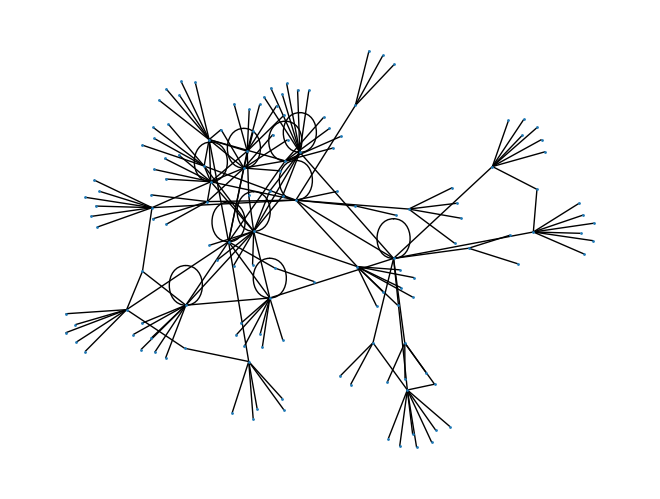

In [10]:
print(graph)
import matplotlib.pyplot as plt
import networkx as nx

nx.draw(graph, node_size=1)

## Graph Encoder GCN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np

### Adjacent Graph and Feature Graph

In [7]:
# graph = conceptnet.conceptnet

adjacency_matrix = nx.adjacency_matrix(graph)
adjacency_matrix = adjacency_matrix.todense()

# Convert the graph nodes' attributes to a feature matrix
feature_matrix = np.array([list(graph.nodes[node].values()) for node in graph.nodes()])

print(adjacency_matrix)
print(feature_matrix)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[]


## BERT Encoder

In [9]:
import torch
from transformers import BertTokenizer, BertModel

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode conversation context using BERT with padding and attention masks
def encode_context(context):
    # Tokenize the conversation context
    tokens = []
    attention_masks = []

    for sentence in context:
        tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=True)
        tokens.extend(tokenized_sentence)
        attention_masks.extend([1] * len(tokenized_sentence))

    # Pad or truncate the tokens and attention masks to a fixed length
    max_length = max(len(tokens), tokenizer.max_model_input_sizes['bert-base-uncased'])
    padded_tokens = tokens + [tokenizer.pad_token_id] * (max_length - len(tokens))
    padded_attention_masks = attention_masks + [0] * (max_length - len(attention_masks))

    # Convert tokens and attention masks to PyTorch tensors
    input_ids = torch.tensor([padded_tokens])
    attention_mask = torch.tensor([padded_attention_masks])

    # Generate the BERT embeddings
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][0]  # First element of the outputs tuple (sequence of hidden states)

    return embeddings

# Example usage
context = ["User: Hello, how are you?", "Chatbot: I'm doing well, thank you!"]
embeddings = encode_context(context)

print(embeddings.shape)  # Shape: (max_length, hidden_size) e.g., (512, 768) for BERT-base
print(embeddings)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([512, 768])
tensor([[-0.0788, -0.0266, -0.1045,  ..., -0.2922,  0.1836,  0.5880],
        [ 0.0378, -0.4185, -0.1285,  ..., -0.3039,  1.0848,  0.4501],
        [ 0.0262, -0.0521, -0.6017,  ..., -0.2632,  0.4129,  0.7955],
        ...,
        [-0.0138, -0.3783,  0.1694,  ...,  0.7582,  0.0551, -0.4463],
        [-0.0945, -0.3555,  0.2154,  ...,  0.7831,  0.1306, -0.4165],
        [-0.0541, -0.3674,  0.5777,  ...,  0.4519,  0.1952, -0.2486]])


## ConceptNet Numberbatch

In [22]:
from tqdm import tqdm

f = open('Data/numberbatch-en.txt', encoding='utf-8')
lines = f.readlines()

number_batch_embeddings = {}
for line in tqdm(lines):
    word, embedding = line.split(' ', 1)
    if '_' in word or not word.isalpha():
         continue
    embedding = [float(emb) for emb in embedding.split(' ')]
    number_batch_embeddings[word] = embedding

print(number_batch_embeddings)

100%|██████████| 516783/516783 [00:31<00:00, 16414.58it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
print(len(number_batch_embeddings))

361056


In [19]:
import torch
import torch.nn.functional as F


apple = torch.FloatTensor(number_batch_embeddings['iron'])
fruit = torch.FloatTensor(number_batch_embeddings['gamma_iron'])

print(F.cosine_similarity(apple, fruit, dim=0))
print(len(number_batch_embeddings['apple']))

tensor(0.9056)
300


## Universal Sentence Encoder

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [2]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

USE = hub.load(model_url)

In [5]:
# Example sentences to encode
sentences = [
    "I like to program.",
    "I love programming.",
]

sentence_embeddings = USE(sentences)
corr = np.inner(sentence_embeddings[0], sentence_embeddings[1])
print(type(sentence_embeddings[0].numpy()))

print(corr)
print(sentence_embeddings.shape)

<class 'numpy.ndarray'>
0.7616016
(2, 512)


## Reinforcement Learning State Definition